# 🎓[Training] Student Perf from Gameplay
---
BASELINE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

In [2]:
PATH = '/kaggle/input/predict-student-performance-from-game-play'

train = pd.read_csv(f'{PATH}/train.csv')
labels = pd.read_csv(f'{PATH}/train_labels.csv')
labels['session'] = labels['session_id'].apply(lambda x: int(x.split('_')[0]))
labels['question'] = labels['session_id'].apply(lambda x: int(x.split('_')[1][1:]))
labels.sample(frac=1).head()

,session_id,correct,session,question
33657,22020417433057480_q3,1,22020417433057480,3
96467,21000417084002420_q9,1,21000417084002420,9
36654,20110415104716590_q4,1,20110415104716590,4
39023,21020116462854464_q4,1,21020116462854464,4
61252,21000512383584704_q6,0,21000512383584704,6


In [3]:
train.head(1)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4


# Feature engineering

In [4]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time', 'level', 'page', 'room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [5]:
def feature_engineer(train):
    dfs = []
    group_cols = ['session_id', 'level_group']
    
    # Nb of unique values in groups for cat cols
    for c in CATS:
        tmp = train.groupby(group_cols)[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)

    # Mean of groups for num cols
    for c in NUMS:
        tmp = train.groupby(group_cols)[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)

    # Std of groups for num cols
    for c in NUMS:
        tmp = train.groupby(group_cols)[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    
    # One-hot encode the events
    for c in EVENTS:
        train[c] = (train['event_name'] == c).astype('int8')

    # Sum the events and elapsed time in groups
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(group_cols)[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    
    # Drop the events after the sum
    train = train.drop(EVENTS, axis=1)
    
    df = pd.concat(dfs, axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')

    return df

In [6]:
%%time
df = feature_engineer(train)
print(df.shape)
df.head()

(35337, 31)
CPU times: user 1min 7s, sys: 1.06 s, total: 1min 8s
Wall time: 1min 8s


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,screen_coor_x_mean,screen_coor_y_mean,hover_duration_mean,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,-1.0,7.701275,-71.413749,448.410256,383.044872,2389.500000,49246.539458,1.230975,-1.000000,399.296040,129.292411,214.871000,104.082743,3227.370757,81.0,22.0,28.0,11.0,4.0,8,2.0,4,1,14155937
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,-1.0,-130.347170,-162.004310,442.489796,379.301020,899.925926,126666.129584,2.358652,-1.000000,622.061375,230.370874,240.280218,99.067861,1305.088265,170.0,123.0,60.0,20.0,14.0,10,6.0,3,1,437052322
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,-1.0,14.306062,-57.269322,451.950943,378.784906,969.333333,80175.676658,2.096919,-1.000000,357.227700,137.409476,203.268560,120.255453,1316.408315,103.0,104.0,12.0,28.0,9.0,9,8.0,1,1,105732736
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,0.0,-84.045960,-53.671082,358.223077,370.723077,1378.750000,67372.714092,1.232616,0.000000,445.980040,156.186242,252.554707,121.062929,2114.876406,49.0,18.0,36.0,15.0,3.0,5,3.0,2,1,13571045
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,5.1,-30.762282,-142.861892,462.852490,387.930077,720.384921,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518,637.0,145.0,65.0,83.0,186.0,14,45.0,5,1,3241011333


# Train XGBoost model

In [7]:
FEATURES = [c for c in df.columns if c != 'level_group']
SESSIONS = df.index.unique()
print("Nb of features used for training:", len(FEATURES))
print("Nb of different sessions:", len(SESSIONS))

Nb of features used for training: 30
Nb of different sessions: 11779


In [8]:
# Model parameters
xgb_params = {'objective': 'binary:logistic',
              'eval_metric': 'logloss',
              'learning_rate': 0.05,
              'max_depth': 4,
              'n_estimators': 1000,
              'early_stopping_rounds': 50,
              'tree_method': 'hist',
              'subsample': 0.8,
              'colsample_bytree': 0.4,
              'use_label_encoder': False}

# Prepare CV
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(SESSIONS), 18)), index=SESSIONS)
models = {}

# Compute CV score with 5-group K-fold
for i, (train_index, valid_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('\033[1m\033[94m-' * 80, f"\n{' ' * 35}FOLD {i + 1}")
    print('-' * 80, '\033[0m')

    # Iterate from question 1 to 18
    for q in range(1, 19):
        
        # Select the question group
        if q <= 3: grp = '0-4'
        elif q <=13: grp = '5-12'
        elif q <= 22: grp = '13-22'
            
        # Train data
        train_x = df.iloc[train_index]
        train_x = train_x[train_x.level_group == grp]
        train_sessions = train_x.index.values
        train_y = labels[labels.question == q]\
            .set_index('session').loc[train_sessions]
        
        # Valid data
        valid_x = df.iloc[valid_index]
        valid_x = valid_x[valid_x.level_group == grp]
        valid_sessions = valid_x.index.values
        valid_y = labels[labels.question == q]\
            .set_index('session').loc[valid_sessions]
        
        # Train model
        clf = XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'),
                train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'),
                           valid_y['correct'])],
                verbose=0)
        
        print(f'Q{q}({clf.best_ntree_limit}), ', end='')
        
        # Save and predict valid
        models[f'{grp}_{q}'] = clf
        oof.loc[valid_sessions, q - 1] = clf.predict_proba(valid_x[FEATURES])[:, 1]

    print()

-------------------------------------------------------------------------------- 
                                   FOLD 1
-------------------------------------------------------------------------------- 
Q1(197), Q2(133), Q3(92), Q4(216), Q5(123), Q6(187), Q7(107), Q8(66), Q9(122), Q10(136), Q11(89), Q12(78), Q13(170), Q14(124), Q15(191), Q16(77), Q17(91), Q18(216), 
-------------------------------------------------------------------------------- 
                                   FOLD 2
-------------------------------------------------------------------------------- 
Q1(138), Q2(115), Q3(120), Q4(120), Q5(78), Q6(118), Q7(95), Q8(65), Q9(136), Q10(109), Q11(61), Q12(68), Q13(74), Q14(172), Q15(120), Q16(84), Q17(41), Q18(103), 
-------------------------------------------------------------------------------- 
                                   FOLD 3
-------------------------------------------------------------------------------- 
Q1(65), Q2(118), Q3(125), Q4(92), Q5(68), Q6(68), Q7

In [9]:
# Put true labels into dataframe with 18 columns such as oof
true = oof.copy()
for q in range(1, 19):
    tmp = labels.loc[labels.question == q].set_index('session')
    true[q - 1] = tmp['correct'].values

In [10]:
# Find the optimal threshold for the final preditions
scores = []
thresholds = []
best_score = 0
best_threshold = 0

for thr in tqdm(np.arange(0.4, 0.81, 0.01)):
    preds = (oof.values > thr).astype(int).reshape(-1)
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(thr)
    if m > best_score:
        best_score = m
        best_threshold = thr

  0%|          | 0/41 [00:00<?, ?it/s]

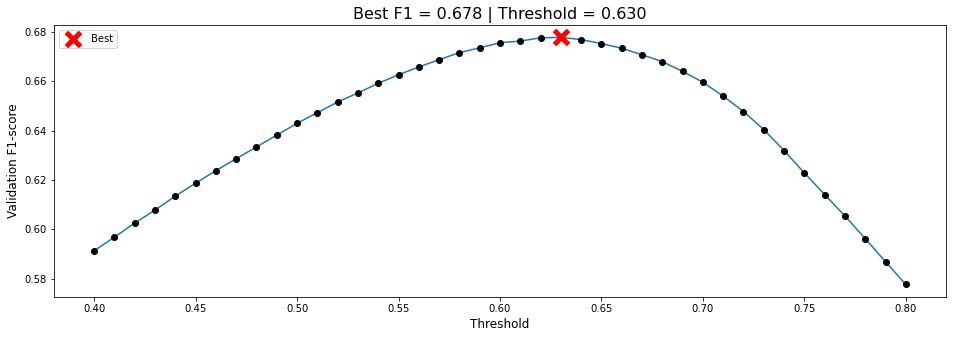

In [11]:
plt.figure(figsize=(16, 5))
plt.scatter(best_threshold, best_score, s=200,
            marker='x', color='red', lw=5, zorder=2)
plt.plot(thresholds, scores, zorder=0)
plt.scatter(thresholds, scores, color='black')
plt.legend(['Best'], loc='upper left')
plt.xlabel("Threshold", size=12)
plt.ylabel("Validation F1-score", size=12)
plt.title(f"Best F1 = {best_score:.3f} | Threshold = {best_threshold:.3f}", size=16)
plt.show()

In [12]:
print(f"Using optimal threshold of {best_threshold:.3f}")
print('-' * 35)
for k in range(18):
    
    # Compute F1 score per question
    preds = (oof[k].values > best_threshold).astype(int)
    m = f1_score(true[k].values, preds, average='macro')
    print(f" Q{k}: F1 = {m:.3f}")
    
preds = (oof.values.reshape((-1)) > best_threshold).astype('int')
m = f1_score(true.values.reshape((-1)), preds, average='macro')
print('-' * 35)
print(f"Overall F1 = {m:.3f}")

Using optimal threshold of 0.630
-----------------------------------
 Q0: F1 = 0.594
 Q1: F1 = 0.495
 Q2: F1 = 0.487
 Q3: F1 = 0.612
 Q4: F1 = 0.566
 Q5: F1 = 0.609
 Q6: F1 = 0.590
 Q7: F1 = 0.523
 Q8: F1 = 0.603
 Q9: F1 = 0.493
 Q10: F1 = 0.593
 Q11: F1 = 0.499
 Q12: F1 = 0.432
 Q13: F1 = 0.607
 Q14: F1 = 0.502
 Q15: F1 = 0.456
 Q16: F1 = 0.546
 Q17: F1 = 0.490
-----------------------------------
Overall F1 = 0.678


# Inference

In [13]:
# Use the competition env
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

# Clear memory (max allowed 8GB)
import gc
del train, labels, df, oof, true
_ = gc.collect()

In [14]:
limits = {'0-4': (1, 4), '5-12': (4, 14), '13-22': (14, 19)}

for (sample_submission, test) in iter_test:
    
    df = feature_engineer(test)
    grp = test.level_group.values[0]
    a, b = limits[grp]
    
    for q in range(a, b):
        clf = models[f'{grp}_{q}']
        p = clf.predict_proba(df[FEATURES])[:, 1]
        mask = sample_submission.session_id.str.contains(f'q{q}')
        sample_submission.loc[mask, 'correct'] = int(p.item() > best_threshold)
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


# Submission.csv

In [15]:
df = pd.read_csv('submission.csv')
print(df.shape)
df

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090312143683264_q1,0
4,20090312143683264_q2,1
5,20090312143683264_q3,1
6,20090312331414616_q1,1
7,20090312331414616_q2,1
8,20090312331414616_q3,1
9,20090109393214576_q4,1


In [16]:
print(df.correct.mean())

0.5555555555555556


In [17]:
# # Model parameters
# xgb_params = {'objective': 'binary:logistic',
#               'eval_metric': 'logloss',
#               'learning_rate': 0.05,
#               'max_depth': 4,
#               'n_estimators': 1000,
#               'early_stopping_rounds': 50,
#               'tree_method': 'hist',
#               'subsample': 0.8,
#               'colsample_bytree': 0.4,
#               'use_label_encoder': False}

# # Retrain with all the data
# models = {}

# # Iterate from question 1 to 18
# for q in range(1, 19):
        
#     # Select the question group
#     if q <= 3: grp = '0-4'
#     elif q <=13: grp = '5-12'
#     elif q <= 22: grp = '13-22'
            
#     # Train data
#     train_x = df[df.level_group == grp]
#     train_y = labels[labels.question == q].set_index('session')
        
#     # Train model
#     clf = XGBClassifier(**xgb_params)
#     clf.fit(train_x[FEATURES].astype('float32'),
#             train_y['correct'],
#             verbose=0)
        
#     print(f'Q{q}({clf.best_ntree_limit}), ', end='')
        
#     # Save model
#     models[f'{grp}_{q}'] = clf

# print()